In [1]:
from copy import deepcopy

import numpy as np

from matplotlib import pyplot as plt
from citk.layer import Dense, GMDHLayer
from citk.model import FFN
from citk.functions import ReLU, Linear
from citk.losses import MSE
from citk.optimisers import SGDOptimizer

from utils import get_and_process_boston_dataset, visualise_boston, seed_everything

%matplotlib inline

In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

# Data

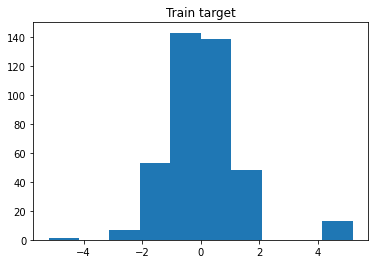

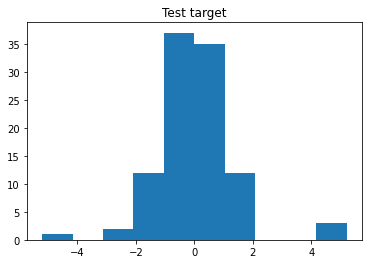

In [2]:
RANDOM_SEED = 42

seed_everything(RANDOM_SEED)

X_train, X_test, y_train, y_test = get_and_process_boston_dataset(random_state=RANDOM_SEED)

visualise_boston(X_train, X_test, y_train, y_test)

# GMDH Hypersearh

## Possible architectures

If we have one GMDH layer - GMDH -> Dense

If we have two or more GMDH layers - ( GMDH -> Dense (F - outputs) ) * (N_GMDH_layers-1) -> GMDH -> Dense

In [4]:
do_hypersearh = True
n_gmdh_layers = 1
best_activations = 16
all_metrics = []
best_model = None
best_history = None

while do_hypersearh:  
    
    if n_gmdh_layers == 1:
         layer_specs = [
             GMDHLayer(poli_type='partial_quadratic'),
         ]
    else:
        layer_specs = []
        for j in range(n_gmdh_layers - 1):
            layer_specs += [
                 GMDHLayer(poli_type='partial_quadratic'),
                 Dense(best_activations, nonlinearity=Linear)
             ] 
        layer_specs += [GMDHLayer(poli_type='partial_quadratic')]
        
    layer_specs += [Dense(1, nonlinearity=Linear)]
        
    print("Layer structure")
    print(layer_specs)

    model = FFN(
        input_shape=X_train.shape[1], 
        layer_specs=layer_specs, 
        loss=MSE, 
        reg_coef=0.01
    )
    
    trained, history = model.fit(
        train_sample=(X_train, y_train),
        validation_sample=(X_test, y_test),
        optimiser=SGDOptimizer(alpha=0.01),
        batch_size=32,
        epochs=5_000,
        verbose=False
    )
    
    prediction = trained.predict(X_test)
    test_metric = MSE(y_test, prediction)[0]
    all_metrics.append(test_metric)
    
    print(f"{n_gmdh_layers} scored {test_metric}")
    
    if len(all_metrics) == 1 or all_metrics[-1] < all_metrics[-2]:
        do_hypersearh = True
        best_history = deepcopy(history)
        best_model = deepcopy(trained)
    else:
        do_hypersearh = False
        
    n_gmdh_layers +=1

Layer structure
[<citk.layer.GMDHLayer object at 0x7f9da7d55a10>, <citk.layer.Dense object at 0x7f9da7d55a90>]



1 scored 0.5934431713783626
Layer structure
[<citk.layer.GMDHLayer object at 0x7f9df9699450>, <citk.layer.Dense object at 0x7f9da74fa490>, <citk.layer.GMDHLayer object at 0x7f9da7d41110>, <citk.layer.Dense object at 0x7f9da74f74d0>]



2 scored 0.3784503973496658
Layer structure
[<citk.layer.GMDHLayer object at 0x7f9df96a0110>, <citk.layer.Dense object at 0x7f9db64b7510>, <citk.layer.GMDHLayer object at 0x7f9db2d890d0>, <citk.layer.Dense object at 0x7f9da7e6e490>, <citk.layer.GMDHLayer object at 0x7f9da7e6ec50>, <citk.layer.Dense object at 0x7f9da7e6e810>]



3 scored 0.34464557995660156
Layer structure
[<citk.layer.GMDHLayer object at 0x7f9daa9d91d0>, <citk.layer.Dense object at 0x7f9db2da9e10>, <citk.layer.GMDHLayer object at 0x7f9db2ea5410>, <citk.layer.Dense object at 0x7f9da7e9eb10>, <citk.layer.GMDHLayer object at 0x7f9da7e9e910>, <citk.layer.Dense object at 0x7f9da7e9ed10>, <citk.layer.GMDHLayer object at 0x7f9da7e9e2d0>, <citk.layer.Dense object at 0x7f9da7e9ef90>]



4 scored 1.9006665022221843


# Predict and Visualise losses

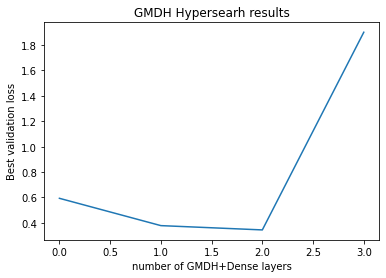

In [5]:
plt.title('GMDH Hypersearh results')
plt.plot(all_metrics)
plt.xlabel('number of GMDH+Dense layers')
plt.ylabel('Best validation loss')
plt.show()

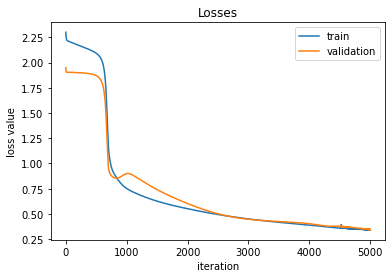

In [6]:
plt.title('Losses')
plt.plot(best_history['train_loss'], label='train')
plt.plot(best_history['validation_loss'], label='validation')
plt.xlabel('iteration')
plt.ylabel('loss value')
plt.legend()
plt.show()

In [7]:
prediction = best_model.predict(X_test)
prediction_train = best_model.predict(X_train)

print(f"Test MSE: {MSE(y_test, prediction)[0]}")
print(f"Train MSE: {MSE(y_train, prediction_train)[0]}")

Test MSE: 0.34464557995660156
Train MSE: 0.19344533102377806


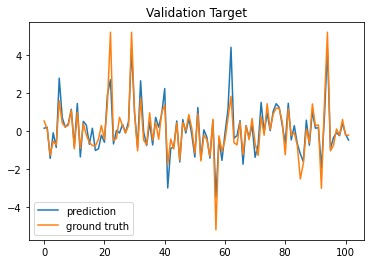

In [8]:
plt.title('Validation Target')
plt.plot(prediction, label='prediction')
plt.plot(y_test, label='ground truth')
plt.legend()
plt.show()

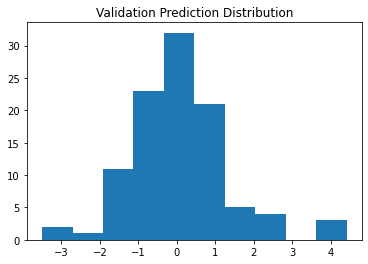

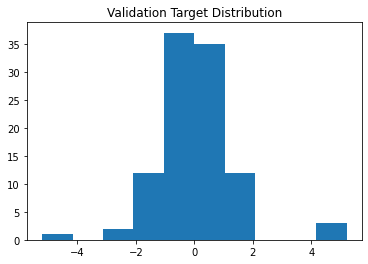

In [9]:
plt.title('Validation Prediction Distribution')
plt.hist(prediction)
plt.show()

plt.title('Validation Target Distribution')
plt.hist(y_test)
plt.show()